# Parcial II MLT

* Esta prueba es INDIVIDUAL. El intercambio de información con otro estudiante por cualquier medio está terminantemente prohibido.
* Cualquier irregularidad con respecto a la regla anterior será considerada fraude.
* Dentro del código va encontrar mensajes como "NO MODIFICAR", y "MODIFICAR", indicando explicitamente que debe modificar o no modificar parte del código que es entregado.
* Responda el examen en los espacios proporcionados, celdas marcadas como "INGRESE AQUÍ SU RESPUESTA". Si necesita agregar celdas lo puede hacer, solo asegurese de no borrar las existentes.
* Preste particular atención al orden y claridad de lo que entrega.
* No olvide enviar el examen por BN antes de las 8:50pm. 
* Todas las preguntas deben ser contestadas en este notebook. 

IMPORTANTE: Soy consciente de que cualquier tipo de fraude en los exámenes es considerado como una falta grave en la Universidad. Al entregar este examen doy expreso testimonio de que este trabajo fue desarrollado de acuerdo con las normas establecidas. Del mismo modo, aseguro que no participe en ningún tipo de fraude.

# Problema: Segmentación de Imágenes

El objetivo es "segmentar" o "dividir" una imagen en diferentes áreas, donde cada área generalmente representa una categoría. Por ejemplo, cuando Zoom o Google Meet muestran un fondo personalizado detrás de usted en una videollamada, utilizan un modelo de segmentación de imágenes para diferenciar su rostro y lo que hay detrás, con precisión de píxel. Hay dos sabores diferentes de segmentación de imágenes:

**Segmentación semántica**, donde cada píxel se clasifica de forma independiente en una categoría semántica, como "gato". Si hay dos gatos en la imagen, todos los píxeles correspondientes se asignan a la misma categoría genérica de "gato".

**Segmentación de instancias**, que busca no solo clasificar los píxeles de la imagen por categoría, sino también analizar instancias de objetos individuales. En una imagen con dos gatos, la segmentación de instancias trataría "gato 1" y "gato 2" como dos clases separadas de píxeles.

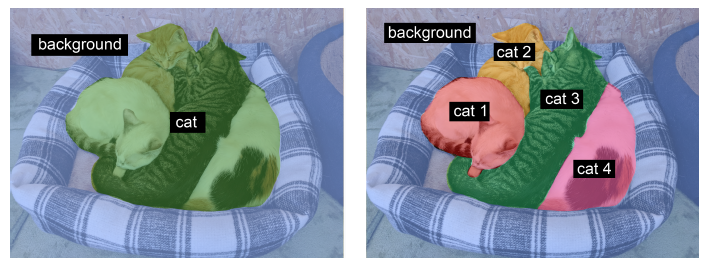

Nos este parcial nos centraremos en la **segmentación semántica** de imágenes de gatos/perros y deberá construir un modelo del cual pueda aprender a distinguir el sujeto principal y su trasfondo.

Trabajaremos con el conjunto de datos Oxford-IIIT Pets:

     https://www.robots.ox.ac.uk/~vgg/data/pets/
     
Para su facilidad hemos preparado un par de zips reducido que puede descargar de: https://www.dropbox.com/sh/c8d5kjlw9k33gvr/AABz_HBiu4igdXJaP7aLnaVZa?dl=0


Contiene 7.390 imágenes de varias razas de gatos y perros, junto con una "mascara de segmentación" para cada imagen que separa el primer plano (lo que nos interesa) y fondo (lo que no nos interesa). Una máscara de segmentación es equivalente a una etiqueta: es una imagen del mismo tamaño que la imagen de entrada, con un solo canal de color donde cada valor entero corresponde a la clase del píxel correspondiente en la imagen de entrada.

En nuestro caso, los píxeles de nuestras máscaras de segmentación pueden tomar uno de tres valores enteros:

* **1. (Primer plano)**
* **2. (Fondo)**
* **3. (Contorno)**


In [ ]:
import os
# os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import layers

input_dir = "./data/ImageSegmentation/images"  #MODIFICAR A SU CARPETA O DRIVE#
target_dir = "./data/ImageSegmentation/annotations/trimaps/" #MODIFICAR A SU CARPETA O DRIVE#

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

Las imágenes de entrada se almacenan como un archivo JPG en la carpeta images/ (como images/Abyssinian_1.jpg), y la máscara de segmentación correspondiente se almacena como un archivo PNG con el mismo nombre en la carpeta annotations/trimaps/ (como annotations/ trimaps/Abisinio_1.png).

In [ ]:
# DIBUJAR LA IMAGEN 10
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[10]))


In [ ]:
## Las etiquetas originales son 1, 2 y 3. Restamos 1 para que las etiquetas varíen de 0 a 2
## luego multiplicamos por 127 para que las etiquetas se conviertan en 0 (negro), 127 (gris), 254 (casi blanco).

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

# Usamos color_mode='escala de grises' para que la imagen que cargamos se trate como si tuviera un solo canal de color.
img = img_to_array(load_img(target_paths[10], color_mode="grayscale"))
display_target(img)

In [ ]:
##NO MODIFICAR##

#El contenido de esta celda cargua las entradas y objetivos en dos matrices NumPy. 
#Tiene que trabajar a partir de las variables aca generadas.

import numpy as np
import random

# Deseo tamaño 200x200
img_size = (200, 200)
# Total number of samples
num_imgs = len(input_img_paths)


# Realizamos un shuffle a las rutas de los archivos (originalmente se ordenaron por raza del animal). 
# Usamos la misma semilla (400) en ambas declaraciones para garantizar replicabilidad. NO MODIFICAR 
random.Random(400).shuffle(input_img_paths)
random.Random(400).shuffle(target_paths)


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
            load_img(path, target_size=img_size, color_mode="grayscale"))
    # Subtract 1 so that our labels becomes 0, 1, and 2.
    img = img.astype("uint8") - 1
    return img

# Carguamos todas las imágenes en la matriz input_imgs (float32) 
# y sus máscaras en la matriz targets uint8. 
# Las entradas tienen 3 canales (valores RBG) y los objetivos (mascaras) tienen un solo canal (que contiene etiquetas de números enteros).
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])


#Guardamos 1000 ejemplos para validación.
num_val_samples = 1000

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## PUNTO 1: Construcción de un modelo a partir de una arquitectura establecida (20pts)

Para resolver este problema usted debe implementar la arquitectura descrita por la imagen. Recuerde:
* En la capa de entrada (Input) debe especificar la entrada esperada.
* En la capa rescaling se deben rescalar los valores de cada pixel al rango [0-1]
* Los parámetros adecuados para las capas Conv2D y Conv2DTranspose (strides y padding) los debe deducir a partir de las dimensiones indicadas.
* Se recomienda usar funciones de activación relu para las capas intermedias. 
* La capa final del modelo (Conv2D_6) debe tener softmax para clasificar cada píxel en las clases de salida especificadas por la segmentación. Debería ser algo similar a: Conv2D(3, num_classes, activation="softmax", padding="same")


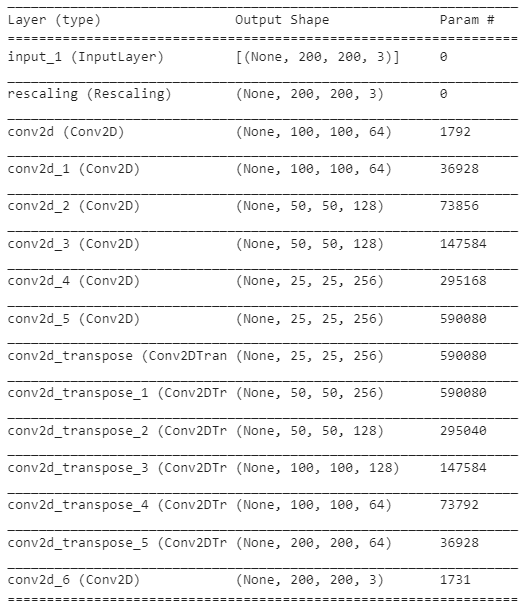

In [ ]:
#SU RESPUESTA AQUI#
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    # Rescale input images to the [0-1] range.
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    # Note how we use padding="same" everywhere to avoid the influence of border
    # padding on feature map size.
    
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    # We end the model with a per-pixel three-way softmax to classify each output pixel
    # into one of our 3 categories.
    outputs = layers.Conv2D(3, num_classes, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = get_model(img_size=img_size, num_classes=3)
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()

# PUNTO 2: Entrenamiento (20pts)

Ahora deberá entrenar su modelo. 
* Seleccione una función de loss apropiada y **explique** la razón de su selección (5pts).
* Debe especificar un callback para guardar el mejor modelo en terminos del loss de validación (5pts). 
* Entrene por 10 (si CPU) o 20 (si GPU colab) epocas y grafique la curva del loss en validación y en traninig. ¿El modelo esta underfitting o overfitting para el número de epocas?  ¿El callback guardo el modelo en que epoca, tiene sentido según la gráfica?.  (10pts). 

Nota: Use un batch apropiado para la memoria de su GPU/CPU. En colab se probo y funciono correctamente con 8, pero no se sorprenda si hay un error de recursos por lo que 4 puede ser una mejor opción.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20
)

mc = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
#SU RESPUESTA AQUI#


# callbacks = [keras.callbacks.ModelCheckpoint("checkpoints/",save_best_only=True)]
callbacks = [es, mc]

history = model.fit(train_input_imgs, train_targets, epochs=200, callbacks=callbacks, batch_size=128,
                    validation_data=(val_input_imgs, val_targets))

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
# model.predict()
input_imgs[0].shape

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
prediction = model.predict(input_imgs)

In [ ]:
input_imgs_float = input_imgs / 255

In [ ]:
train_targets_float = train_targets / 255

In [ ]:
ind = 2
fig, ax = plt.subplots(2, 2, figsize = (12, 12))
ax[0, 0].imshow(input_imgs_float[ind])
ax[0, 1].imshow(prediction[ind])
ax[1, 0].imshow(train_targets_float[ind])